## Data Preparation

***Mounting google drive***

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


***Installing the dependencies***

In [2]:
!pip install inference

***Inferencing on a single image using an open source model***

In [3]:
from inference_sdk import InferenceHTTPClient

CLIENT = InferenceHTTPClient(
    api_url="https://detect.roboflow.com",
    api_key="heSbIdFt08Zl1hxK4i3r"
)

result = CLIENT.infer("/content/drive/MyDrive/images/1000736-6303_jpg.rf.92c0d6c8403755071eac22527c9ad815.jpg", model_id="logistics-sz9jr/2")

In [4]:
print(result["predictions"][0])

{'x': 360.5, 'y': 347.5, 'width': 111.0, 'height': 113.0, 'confidence': 0.8520612716674805, 'class': 'wood pallet', 'class_id': 19, 'detection_id': '5387070c-3435-4eae-beae-7a82d3ac32bb'}


***Displaying the image with the result annotations***



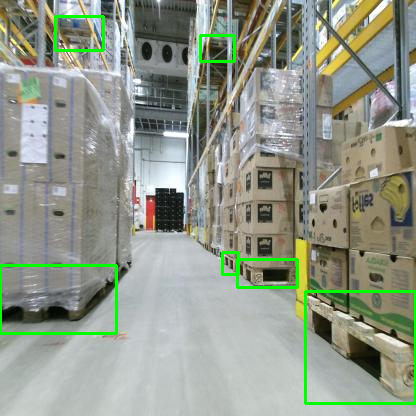

In [5]:
import cv2
from google.colab.patches import cv2_imshow

image_path = "/content/drive/MyDrive/images/1000736-6303_jpg.rf.92c0d6c8403755071eac22527c9ad815.jpg"
image = cv2.imread(image_path)

for prediction in result["predictions"]:
  x = int(prediction["x"])
  y = int(prediction["y"])
  width = int(prediction["width"])
  height = int(prediction["height"])

  x1 = x - width // 2
  y1 = y - height // 2
  x2 = x + width // 2
  y2 = y + height // 2

  cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)

cv2_imshow(image)


***Running model on all the images and storing the annotations in YOLOv11 format.***

In [7]:
import os
from google.colab import drive
from inference_sdk import InferenceHTTPClient
from inference_sdk import InferenceConfiguration
import cv2

CLIENT = InferenceHTTPClient(
    api_url="https://detect.roboflow.com",
    api_key="heSbIdFt08Zl1hxK4i3r"
)

InferenceConfiguration(confidence_threshold=45)

image_folder_path = "/content/drive/MyDrive/images"
output_folder_path = "/content/drive/MyDrive/yolo_annotations"
os.makedirs(output_folder_path, exist_ok=True)

for filename in os.listdir(image_folder_path):
  if filename.endswith((".jpg")):
    image_path = os.path.join(image_folder_path, filename)
    result = CLIENT.infer(image_path, model_id="logistics-sz9jr/2")
    image = cv2.imread(image_path)
    img_width = image.shape[1]
    img_height = image.shape[0]

    annotation_lines = []
    for prediction in result["predictions"]:
      if prediction["class"] == "wood pallet":
        x = float(prediction["x"])
        y = float(prediction["y"])
        width = float(prediction["width"])
        height = float(prediction["height"])

        x_center = x / img_width
        y_center = y / img_height
        width_normalized = width / img_width
        height_normalized = height / img_height

        annotation_lines.append(f"0 {x_center:.6f} {y_center:.6f} {width_normalized:.6f} {height_normalized:.6f}")

    annotation_filepath = os.path.join(output_folder_path, os.path.splitext(filename)[0] + ".txt")
    with open(annotation_filepath, "w") as f:
      if annotation_lines:
        f.write("\n".join(annotation_lines))
      else:
        f.write("")

***Organizing the dataset into training, validation and test sets***

In [8]:
import os
import random
import shutil

image_folder_path = "/content/drive/MyDrive/images"
annotation_folder_path = "/content/drive/MyDrive/yolo_annotations"

train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

train_image_dir = "/content/drive/MyDrive/dataset/train/images"
train_label_dir = "/content/drive/MyDrive/dataset/train/labels"
val_image_dir = "/content/drive/MyDrive/dataset/val/images"
val_label_dir = "/content/drive/MyDrive/dataset/val/labels"
test_image_dir = "/content/drive/MyDrive/dataset/test/images"
test_label_dir = "/content/drive/MyDrive/dataset/test/labels"

os.makedirs(train_image_dir, exist_ok=True)
os.makedirs(train_label_dir, exist_ok=True)
os.makedirs(val_image_dir, exist_ok=True)
os.makedirs(val_label_dir, exist_ok=True)
os.makedirs(test_image_dir, exist_ok=True)
os.makedirs(test_label_dir, exist_ok=True)

image_files = [f for f in os.listdir(image_folder_path) if f.endswith((".jpg"))]
random.shuffle(image_files)

num_images = len(image_files)
num_train = int(train_ratio * num_images)
num_val = int(val_ratio * num_images)
num_test = num_images - num_train - num_val

for i, image_file in enumerate(image_files):
  image_path = os.path.join(image_folder_path, image_file)
  label_file = os.path.splitext(image_file)[0] + ".txt"
  label_path = os.path.join(annotation_folder_path, label_file)

  if i < num_train:
    shutil.copy(image_path, train_image_dir)
    shutil.copy(label_path, train_label_dir)
  elif i < num_train + num_val:
    shutil.copy(image_path, val_image_dir)
    shutil.copy(label_path, val_label_dir)
  else:
    shutil.copy(image_path, test_image_dir)
    shutil.copy(label_path, test_label_dir)

print(f"Dataset split complete:")
print(f"Train images: {len(os.listdir(train_image_dir))}")
print(f"Val images: {len(os.listdir(val_image_dir))}")
print(f"Test images: {len(os.listdir(test_image_dir))}")

Dataset split complete:
Train images: 363
Val images: 77
Test images: 79


***Performing data augmentation by adjusting brightness, contrast, blur and flips.***

In [9]:
import cv2
import numpy as np
import random
import os

def augment_image(image_path, output_path):
  image = cv2.imread(image_path)

  # brightness
  brightness_factor = random.uniform(0.7, 1.3)
  image = cv2.convertScaleAbs(image, alpha=brightness_factor, beta=0)

  # contrast
  contrast_factor = random.uniform(0.7, 1.3)
  image = cv2.addWeighted(image, contrast_factor, np.zeros(image.shape, image.dtype), 0, 0)

  # Gaussian
  if random.random() < 0.5:
    blur_kernel_size = random.choice([3, 5, 7])
    image = cv2.GaussianBlur(image, (blur_kernel_size, blur_kernel_size), 0)

  # flip
  if random.random() < 0.5:
      image = cv2.flip(image, 1)

  cv2.imwrite(output_path, image)


train_image_dir = "/content/drive/MyDrive/dataset/train/images"
label_dir = "/content/drive/MyDrive/yolo_annotations"
train_label_dir = "/content/drive/MyDrive/dataset/train/labels"

for filename in os.listdir(train_image_dir):
  if filename.endswith((".jpg")):
    image_path = os.path.join(train_image_dir, filename)
    output_path = os.path.join(train_image_dir, f"augmented_{filename}")

    label_path = os.path.join(label_dir, os.path.splitext(filename)[0] + ".txt")
    shutil.copy(label_path, os.path.join(train_label_dir, f"augmented_{os.path.splitext(filename)[0]}.txt"))
    augment_image(image_path, output_path)

***Saving the dataset***

In [10]:
!zip -r /content/dataset.zip /content/drive/MyDrive/dataset

  adding: content/drive/MyDrive/dataset/ (stored 0%)
  adding: content/drive/MyDrive/dataset/train/ (stored 0%)
  adding: content/drive/MyDrive/dataset/train/images/ (stored 0%)
  adding: content/drive/MyDrive/dataset/train/images/1576593358-3581605_jpg.rf.e5b76652ab9072795201b7d6faa17903.jpg (deflated 0%)
  adding: content/drive/MyDrive/dataset/train/images/1579164163-8178449_jpg.rf.fb73b1454c0993d419b742374550010e.jpg (deflated 0%)
  adding: content/drive/MyDrive/dataset/train/images/1564564567999-14_jpg.rf.af6adbec4ba415112e0d94b92551d8de.jpg (deflated 1%)
  adding: content/drive/MyDrive/dataset/train/images/1576595800-150642_jpg.rf.08c95de8705199534d5775ceae47c6e5.jpg (deflated 0%)
  adding: content/drive/MyDrive/dataset/train/images/1579165088180-98_jpg.rf.8e3f0cbecc4091ff63372f1c93735365.jpg (deflated 0%)
  adding: content/drive/MyDrive/dataset/train/images/2375456-4422_jpg.rf.59ecf9eb88581176b106baa0018867b8.jpg (deflated 0%)
  adding: content/drive/MyDrive/dataset/train/images/

In [11]:
from google.colab import files
files.download("/content/dataset.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>